# Load data

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv(r"C:\Users\amusali\Desktop\uc3m PhD\05 Analysis\01 Main\03 Python scripts\03 Estimation\02 Top Tech\02 Off deal\raw\10 Sample - top tech, OD, filing date, enhanced.csv")

df.head(20)

C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\3545907625.py:4: DtypeWarning: Columns (26,27,28,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\amusali\Desktop\uc3m PhD\05 Analysis\01 Main\03 Python scripts\03 Estimation\02 Top Tech\02 Off deal\raw\10 Sample - top tech, OD, filing date, enhanced.csv")


,treated_id,control_id,match_id,lambda,mahalanobis_distance,cosine_distance,hybrid_distance,quarter,citations_treated,citations_control,...,resold_date,modnote,assignor,_merge,acq_quarter,actual_quarter,unique_cpc_treated,unique_assignee_treated,unique_cpc_control,unique_assignee_control
0,10009864,10111122,862,0.0,5.681793,0.151367,0.151367,-1,3,0,...,NaN,NaN,INTEL CORPORATION,Master only (1),2019Q4,2019Q3,2,1,0,0
1,10009864,10111122,862,0.0,5.681793,0.151367,0.151367,-2,0,0,...,NaN,NaN,INTEL CORPORATION,Master only (1),2019Q4,2019Q2,0,0,0,0
2,10009864,10111122,862,0.0,5.681793,0.151367,0.151367,-3,1,0,...,NaN,NaN,INTEL CORPORATION,Master only (1),2019Q4,2019Q1,1,1,0,0
3,10009864,10111122,862,0.0,5.681793,0.151367,0.151367,-4,1,0,...,NaN,NaN,INTEL CORPORATION,Master only (1),2019Q4,2018Q4,1,1,0,0
4,10009864,10111122,862,0.0,5.681793,0.151367,0.151367,0,4,0,...,NaN,NaN,INTEL CORPORATION,Master only (1),2019Q4,2019Q4,4,1,0,0
5,10009864,10111122,862,0.0,5.681793,0.151367,0.151367,1,2,0,...,NaN,NaN,INTEL CORPORATION,Master only (1),2019Q4,2020Q1,2,1,0,0
6,10009864,10111122,862,0.0,5.681793,0.151367,0.151367,10,2,0,...,NaN,NaN,INTEL CORPORATION,Master only (1),2019Q4,2022Q2,2,1,0,0
7,10009864,10111122,862,0.0,5.681793,0.151367,0.151367,11,0,0,...,NaN,NaN,INTEL CORPORATION,Master only (1),2019Q4,2022Q3,0,0,0,0
8,10009864,10111122,862,0.0,5.681793,0.151367,0.151367,12,2,0,...,NaN,NaN,INTEL CORPORATION,Master only (1),2019Q4,2022Q4,1,1,0,0
9,10009864,10111122,862,0.0,5.681793,0.151367,0.151367,13,0,0,...,NaN,NaN,INTEL CORPORATION,Master only (1),2019Q4,2023Q1,0,0,0,0


# Run multiperiod DiD by lambda 

## Functions

In [5]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from scipy.stats import ks_2samp

def compute_individual_TE(df,
                          outcome_treated='citations_treated',
                          outcome_control='citations_control',
                          index_cols=['lambda', 'match_id'],
                          quarter_col='quarter',
                          baseline=-1,
                          max_period=16):
    """
    Computes individual treatment effects (TE) for each match.
    
    TE(t) = [treated(t) - treated(baseline)] - [control(t) - control(baseline)]
    
    Only includes matches that have non-missing outcomes for every quarter from 
    the baseline to max_period.
    
    Parameters:
      - df: DataFrame in long format.
      - outcome_treated: Column name for the treated outcome.
      - outcome_control: Column name for the control outcome.
      - index_cols: List of columns that uniquely identify a match (e.g., ['lambda', 'match_id']).
      - quarter_col: Column name for the time period indicator.
      - baseline: Baseline period (e.g., -1 or -2) used for normalization.
      - max_period: Maximum period (quarter) to include.
    
    Returns:
      - TE: DataFrame with individual treatment effects. Its index is a MultiIndex (index_cols)
            and its columns are the quarters used.
      - wide: The wide-format DataFrame (pivoted) used for the computation.
    """
    # Pivot to wide format: rows defined by index_cols, columns = quarter values.
    wide = df.pivot_table(index=index_cols,
                          columns=quarter_col,
                          values=[outcome_treated, outcome_control])
    wide = wide.sort_index(axis=1, level=1)
    
    # Determine required quarters: those between baseline and max_period.
    available_quarters = sorted(wide[outcome_treated].columns)
    required_quarters = [q for q in available_quarters if -4 <= q <= max_period]
    
    # Keep only matches that have non-missing outcomes for all required quarters.
    mask_treated = wide[outcome_treated][required_quarters].notna().all(axis=1)
    mask_control = wide[outcome_control][required_quarters].notna().all(axis=1)
    wide = wide[mask_treated & mask_control]
    sample_size = len(wide)
    print(f"Sample size: {sample_size} matches")
    
    # Compute TE for each quarter:
    # TE(t) = (treated(t) - treated(baseline)) - (control(t) - control(baseline))
    TE = pd.DataFrame(index=wide.index, columns=required_quarters, dtype=float)
    for t in required_quarters:
        TE[t] = (wide[outcome_treated][t] - wide[outcome_treated][baseline]) - \
                (wide[outcome_control][t] - wide[outcome_control][baseline])
    # Force TE(baseline) = 0.
    TE[baseline] = 0
    return TE, wide, sample_size



def estimate_ATT_and_bootstrap(TE, index_col='lambda', n_boot=500, seed=42):
    """
    Estimates the ATT by averaging individual TEs over match_ids and computes bootstrap SEs.
    
    Parameters:
      - TE: DataFrame of individual treatment effects with a MultiIndex (e.g., ['lambda', 'match_id'])
            and columns as quarters.
      - index_col: The grouping variable (e.g., 'lambda') used to compute ATT.
      - n_boot: Number of bootstrap replications.
      - seed: Random seed for reproducibility.
    
    Returns:
      - ATT_long: DataFrame in long format with ATT estimates and bootstrap SEs.
      - boot_results: DataFrame containing bootstrap replications.
    """
    np.random.seed(seed)
    # Compute ATT by averaging TEs within each group (index_col).
    ATT = TE.groupby(level=0).mean()  # rows: groups (e.g., lambda), columns: quarters
    # Reshape to long format.
    ATT_long = ATT.reset_index().melt(id_vars=index_col, var_name='quarter', value_name='ATT')
    ATT_long['quarter'] = ATT_long['quarter'].astype(float)
    
    # Bootstrap SEs: resample match_ids (within each group) and compute mean TEs.
    def bootstrap_ATT_inner(TE_df, n_boot, seed):
        np.random.seed(seed)
        boot_list = []
        # Group by the grouping variable (e.g., lambda)
        for group_val, group in tqdm(TE_df.groupby(level=0), desc="Bootstrapping groups"):
            match_ids = group.index.get_level_values(1).unique()
            for i in tqdm(range(n_boot), desc="Bootstrap replications", leave=False):
                sampled_ids = np.random.choice(match_ids, size=len(match_ids), replace=True)
                sample = group.loc[pd.IndexSlice[group_val, sampled_ids], :]
                boot_est = sample.mean()  # average over matches for each quarter
                boot_est[index_col] = group_val
                boot_est['boot_iter'] = i
                boot_list.append(boot_est)
        boot_df = pd.DataFrame(boot_list)
        return boot_df
    
    boot_results = bootstrap_ATT_inner(TE, n_boot=n_boot, seed=seed)
    # For each lambda and quarter, compute the bootstrap SE.
    boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()
    # Melt the bootstrap SEs into long format (ignoring non-quarter columns)
    boot_se_long = boot_se.melt(id_vars=index_col, var_name='quarter', value_name='se')
    boot_se_long = boot_se_long[boot_se_long['quarter'].apply(lambda x: isinstance(x, (int, float)))]
    boot_se_long['quarter'] = boot_se_long['quarter'].astype(float)
    
    # Merge bootstrap SEs with ATT estimates.
    ATT_long = ATT_long.merge(boot_se_long, on=[index_col, 'quarter'], how='left')
    return ATT_long, boot_results


def plot_ATT(ATT_long, baseline=-1, index_col='lambda', lambda_val=0,
             title='Dynamic ATT (Normalized to Baseline)', figsize=(8,6)):
    """
    Plots the dynamic ATT for a specified group with 95% confidence intervals.
    
    Parameters:
      - ATT_long: DataFrame in long format with columns [index_col, 'quarter', 'ATT', 'se'].
      - baseline: Baseline period used for normalization.
      - index_col: Grouping variable (e.g., 'lambda').
      - lambda_val: Specific value of the grouping variable to plot.
      - title: Plot title.
      - figsize: Figure size.
    """
    # Round lambda values for accurate filtering
    ATT_long[index_col] = ATT_long[index_col].round(2)
    lambda_val = round(lambda_val, 2)
    
    # Filter and sort by quarter
    plot_data = ATT_long[ATT_long[index_col] == lambda_val].sort_values('quarter')
    
    plt.figure(figsize=figsize)
    plt.errorbar(plot_data['quarter'], plot_data['ATT'], 
                 yerr=1.96 * plot_data['se'],
                 fmt='o-', capsize=5, label='ATT')
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(x=baseline, color='black', linestyle='--', label=f'Baseline ({baseline})')
    plt.xlabel('Quarter')
    plt.ylabel('ATT (Dynamic Treatment Effect)')
    plt.title(title)
    # Set the x-axis limits so that the minimum quarter in your data appears on the axis.
    plt.xlim(plot_data['quarter'].min()-0.5, plot_data['quarter'].max()+0.5)
    plt.legend()
    plt.show()



def run_balance_tests(df_sub, values, outcome_treated, outcome_control):
    """
    Input: df for a given lambda

    Returns: a list of all the results
    
    """
    # ---------------------------
    # 1. Balance Tests for Pre-treatment Outcomes (quarters -4 to -1)
    # ---------------------------
    pre_range = [-4, -3, -2, -1]
    df_pre = df_sub[df_sub['quarter'].isin(pre_range)]
    
    # Pivot pre-treatment data: each match_id is a row
    pivot_pre = df_pre.pivot_table(index='match_id',
                                   columns='quarter',
                                   values=values)
    pivot_pre = pivot_pre.dropna()  # only include matches with complete pre data
    
    # Compute average pre-treatment outcomes per match for treated and control
    avg_treated = pivot_pre[outcome_treated].mean(axis=1)
    avg_control = pivot_pre[outcome_control].mean(axis=1)
    
    # Compute SMD: (mean_treated - mean_control) / pooled_sd
    mean_treated = avg_treated.mean()
    mean_control = avg_control.mean()
    var_treated = avg_treated.var()
    var_control = avg_control.var()
    pooled_sd = np.sqrt((var_treated + var_control) / 2)
    smd = (mean_treated - mean_control) / pooled_sd if pooled_sd > 0 else np.nan
    
    # KS test on the distributions of the average outcomes
    ks_stat, ks_p = ks_2samp(avg_treated, avg_control)

    return smd, ks_stat, ks_p



def estimate_by_lambda(df, baseline,  values, outcome_treated, outcome_control, max_period = 20,):
    
  # List to store subgroup (lambda group) results
  all_results = []

  # Get unique lambda values (rounded to 2 decimals)
  unique_lambdas = df['lambda'].round(2).unique()
  unique_lambdas = np.sort(unique_lambdas)


  
  for lam in tqdm(unique_lambdas, desc="Processing lambda groups"):
      # Filter data for the current lambda group
      df_sub = df[df['lambda'].round(2) == lam].copy()

      smd, ks_stat, ks_p = run_balance_tests(df_sub, values, outcome_treated, outcome_control)

      # ---------------------------
      # 2. Dynamic ATT Estimation (with bootstrap SEs)
      # ---------------------------
      # Compute individual treatment effects (TEs) using the pre-defined function.
      TE, wide_sub, sample_size = compute_individual_TE(df_sub,
                                          outcome_treated=outcome_treated,
                                          outcome_control=outcome_control,
                                          index_cols=['lambda', 'match_id'],
                                          quarter_col='quarter',
                                          baseline=baseline,
                                          max_period=max_period)
      
      # Estimate ATT and bootstrap SEs for this lambda group.
      ATT_long, boot_results = estimate_ATT_and_bootstrap(TE, index_col='lambda', n_boot=500, seed=42)
      
      # Filter ATT_long to only include the current lambda group (redundant but safe)
      ATT_long_sub = ATT_long[ATT_long['lambda'] == lam].copy()
      
      # ---------------------------
      # 3. Append Subgroup Information
      # ---------------------------
      ATT_long_sub['sample_size'] = sample_size
      ATT_long_sub['smd'] = smd
      ATT_long_sub['ks_stat'] = ks_stat

      ATT_long_sub['ks_p'] = ks_p
      ATT_long_sub['lambda_val'] = lam  # store the lambda value explicitly

      # Append results for this lambda group
      all_results.append(ATT_long_sub)
      
  # Concatenate results for all lambda groups
  ATT_all = pd.concat(all_results, ignore_index=True)
  return ATT_all

def save_att(ATT_all, root, filename):
    path = os.path.join(root, filename)
    ATT_all.to_csv(path, index=False)

def plot_all_att(ATT_all, baseline, root, filename):

  # Path
  path = os.path.join(root, filename)

  # Graphics
  plt.figure(figsize=(10, 7))
  sns.lineplot(data=ATT_all, x='quarter', y='ATT', hue='lambda_val', marker='o', palette='tab10')
  plt.axhline(0, color='gray', linestyle='--')
  plt.axvline(x=0, color='black', linestyle='--', label=f'Baseline ({baseline})')
  plt.xlabel('Quarter')
  plt.ylabel('ATT (Dynamic Treatment Effect)')
  plt.title('Dynamic ATT by Lambda')
  plt.legend(title='Lambda')
  plt.xlim(ATT_all['quarter'].min()-0.5, ATT_all['quarter'].max()+0.5)

  plt.savefig(f"{path}")	
    

def plot_att_by_lambda(ATT_all, baseline, folder, key):
    

    # Get a sorted list of unique lambda values (rounded to two decimals)
    unique_lambdas = sorted(ATT_all['lambda_val'].unique())

    # Create a color palette with as many colors as there are unique lambda groups
    palette = sns.color_palette('tab10', len(unique_lambdas))

    # Loop over each lambda group and plot separately
    for i, lam in enumerate(unique_lambdas):
        group_data = ATT_all[ATT_all['lambda_val'] == lam].sort_values('quarter')
        
        # Compute lower and upper bounds for the 95% CI
        lower = group_data['ATT'] - 1.96 * group_data['se']
        upper = group_data['ATT'] + 1.96 * group_data['se']
        
        # Create the plot for this lambda group
        plt.figure(figsize=(10, 7))
        plt.plot(group_data['quarter'], group_data['ATT'], marker='o', 
                label=f'Lambda {lam}', color=palette[i])
        plt.fill_between(group_data['quarter'], lower, upper, alpha=0.3, color=palette[i])
        
        # Add reference lines
        plt.axhline(0, color='gray', linestyle='--')
        plt.axvline(x=0, color='black', linestyle='--', label=f'Baseline ({baseline})')
        
        # Add labels and title
        plt.xlabel('Quarter')
        plt.ylabel('ATT (Dynamic Treatment Effect)')
        plt.title(f'Dynamic ATT for Lambda {lam}')
        plt.xlim(ATT_all['quarter'].min()-0.5, ATT_all['quarter'].max()+0.5)
        plt.legend(title='Lambda')
        plt.tight_layout()
        
        # Save the plot to a file (e.g., PNG)
        # Path
        path = os.path.join(folder, f"ATT_{key}_lambda_{lam}.png")
        plt.savefig(path)
        plt.close()


## Estimate for each lambda

Looping over max periods:   0%|          | 0/1 [00:00<?, ?it/s]

Processing lambda groups:   0%|          | 0/21 [00:00<?, ?it/s]

Sample size: 867 matches


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

Sample size: 867 matches


C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

Sample size: 867 matches


C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

Sample size: 867 matches


C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

Sample size: 867 matches


C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

Sample size: 867 matches


C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Sample size: 867 matches


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Sample size: 867 matches


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Sample size: 867 matches


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

Sample size: 867 matches


C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

Sample size: 867 matches


C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

Sample size: 867 matches


C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Sample size: 867 matches


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Sample size: 867 matches


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Sample size: 867 matches


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

Sample size: 867 matches


C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Sample size: 867 matches


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Sample size: 867 matches


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Sample size: 867 matches


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

Sample size: 867 matches


C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Sample size: 867 matches


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


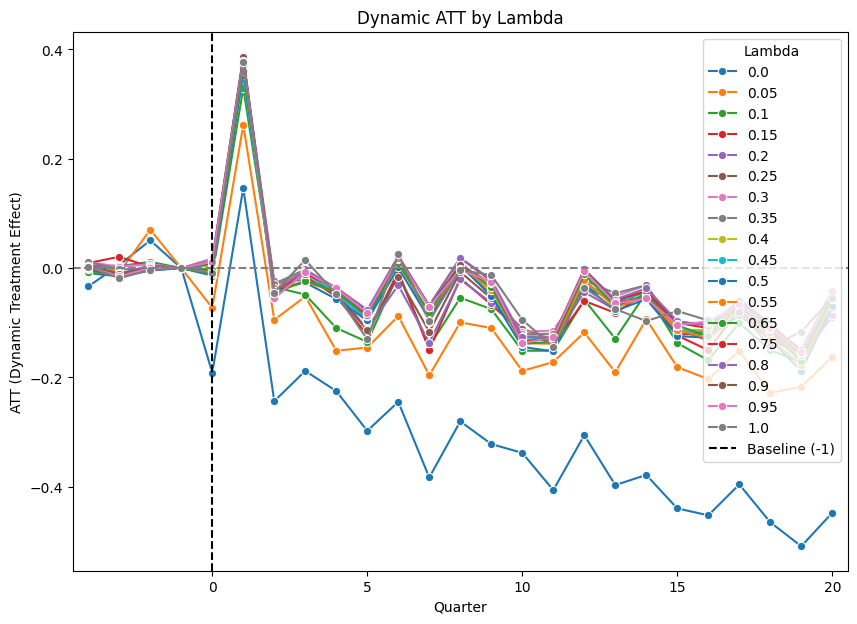

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from scipy.stats import ks_2samp


# Max periods
max_period_list = [20]

for period in tqdm(max_period_list, desc = "Looping over max periods"):

    # Run balance tests and estimate ATT
    ATT_all = estimate_by_lambda(df, -1, ['unique_cpc_treated', 'unique_cpc_control'], outcome_treated='unique_cpc_treated', outcome_control='unique_cpc_control', max_period=period)
    
    # Save results
    save_att(ATT_all, fr'C:\Users\amusali\Desktop\uc3m PhD\05 Analysis\01 Main\03 Python scripts\03 Estimation\02 Top Tech\02 Off deal\out\enhanced', f'ATT_unique_cpc_{period}.csv')

    # Save graph of all ATTs
    plot_all_att(ATT_all, -1, fr'C:\Users\amusali\Desktop\uc3m PhD\05 Analysis\01 Main\03 Python scripts\03 Estimation\02 Top Tech\02 Off deal\out\enhanced', f'ATT_unique_cpc_{period}.png')

    # Save graphs of ATTs by lambda
    plot_att_by_lambda(ATT_all, -1, fr'C:\Users\amusali\Desktop\uc3m PhD\05 Analysis\01 Main\03 Python scripts\03 Estimation\02 Top Tech\02 Off deal\out\enhanced', key = "cpc")





# Estimate - Unique assignees

Looping over max periods:   0%|          | 0/1 [00:00<?, ?it/s]

Processing lambda groups:   0%|          | 0/21 [00:00<?, ?it/s]

Sample size: 867 matches


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Sample size: 867 matches


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

Sample size: 867 matches


C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Sample size: 867 matches


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Sample size: 867 matches


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

Sample size: 867 matches


C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Sample size: 867 matches


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

Sample size: 867 matches


C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Sample size: 867 matches


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Sample size: 867 matches


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

Sample size: 867 matches


C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

Sample size: 867 matches


C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

Sample size: 867 matches


C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

Sample size: 867 matches


C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Sample size: 867 matches


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

Sample size: 867 matches


C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

Sample size: 867 matches


C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

Sample size: 867 matches


C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

Sample size: 867 matches


C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

Sample size: 867 matches


C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

Sample size: 867 matches


C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


Bootstrapping groups:   0%|          | 0/1 [00:00<?, ?it/s]

Bootstrap replications:   0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\amusali\AppData\Local\Temp\ipykernel_15344\1870098444.py:108: FutureWarning: The provided callable <function std at 0x000001A2771E5E40> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  boot_se = boot_results.groupby(index_col).agg(np.std).reset_index()


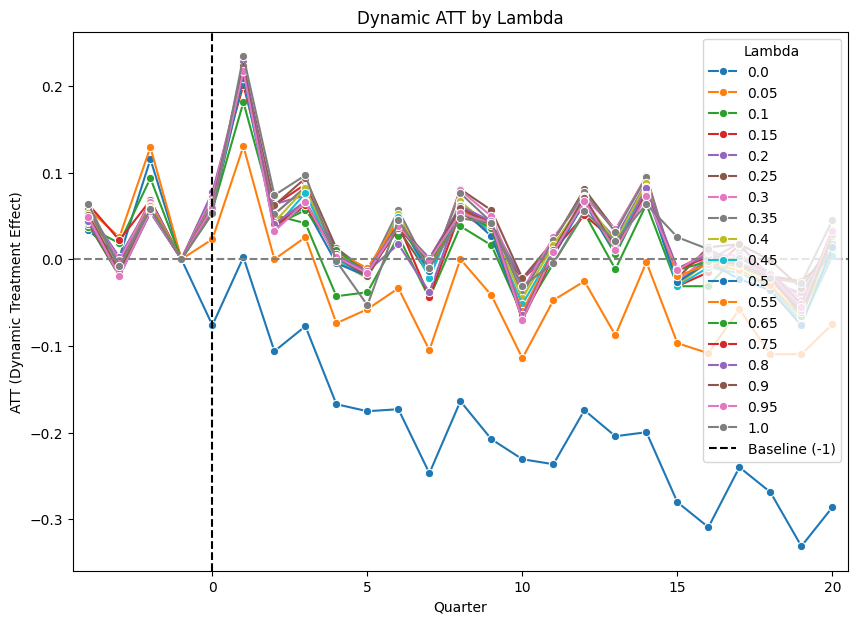

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from scipy.stats import ks_2samp


# Max periods
max_period_list = [20]

for period in tqdm(max_period_list, desc = "Looping over max periods"):

    # Run balance tests and estimate ATT
    ATT_all = estimate_by_lambda(df, -1, ['unique_assignee_treated', 'unique_assignee_control'], outcome_treated='unique_assignee_treated', outcome_control='unique_assignee_control', max_period=period)
    
    # Save results
    save_att(ATT_all, fr'C:\Users\amusali\Desktop\uc3m PhD\05 Analysis\01 Main\03 Python scripts\03 Estimation\02 Top Tech\02 Off deal\out\enhanced', f'ATT_unique_ass_{period}.csv')

    # Save graph of all ATTs
    plot_all_att(ATT_all, -1, fr'C:\Users\amusali\Desktop\uc3m PhD\05 Analysis\01 Main\03 Python scripts\03 Estimation\02 Top Tech\02 Off deal\out\enhanced', f'ATT_unique_ass_{period}.png')

    # Save graphs of ATTs by lambda
    plot_att_by_lambda(ATT_all, -1, fr'C:\Users\amusali\Desktop\uc3m PhD\05 Analysis\01 Main\03 Python scripts\03 Estimation\02 Top Tech\02 Off deal\out\enhanced', key = "ass")


